In [784]:
#####Hierarchical Non Negative Matrix Factorization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [785]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 5000   #ユーザー数
item = 2500   #アイテム数
pt = np.random.poisson(np.random.gamma(27.5, 1/0.25, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #
vec_k = np.repeat(1, k)

In [786]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]

In [787]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(2.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
for j in range(item):
    item_list[j] = index[item_id==j]
    item_vec[j] = np.repeat(1, len(item_list[j]))

0
1000
2000
3000
4000


In [788]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 3; k2 = 5; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 4; k2 = 5; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [789]:
####応答変数の生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##NMFのパラメータを生成
    #ガンマ分布の尺度パラメータを生成
    alpha_u = np.random.normal(0, 0.3, k*col_u).reshape(col_u, k)
    alpha_v = np.random.normal(0, 0.3, k*col_v).reshape(col_v, k)
    alpha_ut = alpha_u; alpha_vt = alpha_v
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    #ガンマ分布の形状パラメータを生成
    beta_u = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_v = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_ut = beta_u; beta_vt = beta_v

    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(lambda_u, 1/beta_u)
    theta_v = np.random.gamma(lambda_v, 1/beta_v)
    theta_ut = theta_u; theta_vt = theta_v

    ##ポアソン分布から応答変数を生成
    WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)
    y = np.random.poisson(WH, hhpt)
    y_vec = y.reshape(hhpt, 1)
    
    #break条件
    if (np.max(y) < 75) & (np.max(y) > 25):
        break

1
2
3
4
5


2217442
4.039027038054368


(array([3.54357e+05, 1.45714e+05, 3.75110e+04, 8.64900e+03, 2.08200e+03,
        5.71000e+02, 8.40000e+01, 2.90000e+01, 5.00000e+00, 2.00000e+00]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

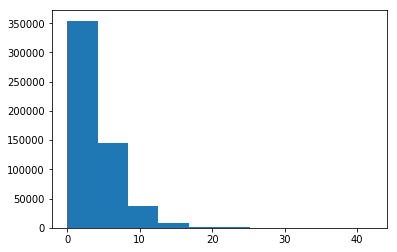

In [790]:
#生成した応答変数を確認
print(np.sum(y))
print(np.mean(y))
plt.hist(y)

In [791]:
####マルコフ連鎖モンテカルロ法でHierarchical NMFを推定####
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

In [792]:
value = np.random.gamma(1, 1/0.25, 10000)
print(np.mean(value))
np.std(value)

4.012145396714471


4.002335439667481

In [793]:
#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

In [794]:
#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [795]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

In [796]:
#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

In [797]:
#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [798]:
##アルゴリズムの設定
R = 5000
keep = 4
burnin = int(1000/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.0025
L = 3

In [799]:
##事前分布の設定
gamma_u = np.repeat(0, col_u)
gamma_v = np.repeat(0, col_v)
tau_inv1 = np.linalg.inv(np.diag(np.repeat(100, col_u)))
tau_inv2 = np.linalg.inv(np.diag(np.repeat(100, col_v)))
tau_inv = np.linalg.inv(np.diag(np.repeat(100, k)))

In [800]:
##パラメータの真値
#ガンマ分布の尺度パラメータの真値
alpha_u = alpha_ut
alpha_v = alpha_vt
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータの真値
beta_u = beta_ut
beta_v = beta_vt

#行列分解のパラメータの真値
theta_u = theta_ut
theta_v = theta_vt
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [801]:
##パラメータの初期値
#ガンマ分布の尺度パラメータの初期値
alpha_u = np.random.normal(0, 0.1, k*col_u).reshape(col_u, k)
alpha_v = np.random.normal(0, 0.1, k*col_v).reshape(col_v, k)
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータを初期値
beta_u = 1.0
beta_v = 1.0

#ガンマ分布から行列分解のパラメータを生成
theta_u = np.random.gamma(lambda_u, 1/beta_u)
theta_v = np.random.gamma(lambda_v, 1/beta_v)
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [802]:
##サンプリング結果の格納用配列
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
ALPHA_U = np.zeros((col_u, k, int(R/keep)))
ALPHA_V = np.zeros((col_v, k, int(R/keep)))
BETA_U = np.zeros((int(R/keep)))
BETA_V = np.zeros((int(R/keep))) 

In [803]:
##ユーザーおよびアイテムのインデックスを作成
#スパース行列作成用のid
no_id = np.repeat(np.arange(hhpt), k)
k_id = np.repeat(np.arange(k), hhpt).reshape(hhpt, k, order="F").reshape(-1)

#個別に和を取るためのスパース行列
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()

In [804]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.poisson.logpmf(y, np.mean(y)))
print(LLst)

#真値での対数尤度
WH_T = np.dot(theta_ut[user_id, ] * theta_vt[item_id, ], vec_k)   #期待値
LLbest = np.sum(scipy.stats.poisson.logpmf(y, WH_T))
print(LLbest)

-1460701.269164469
-1092083.821320341


In [ ]:
####パラメータをサンプリング####
for rp in range(R):

    ##ユーザー特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec2 = theta_v[item_id, ]
    gamma = (theta_u[user_id, ] * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    W1 = np.array(np.dot(user_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)), shape=(hhpt, k)).tocsr()).todense()) + lambda_u
    W2 = np.array(np.dot(user_dt, sparse.coo_matrix((theta_vec2.reshape(-1), (no_id, k_id)), shape=(hhpt, k)).tocsr()).todense()) + beta_u

    #ガンマ分布よりパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)
    theta_u = theta_u / np.repeat(np.sum(theta_u, axis=0), hh).reshape(hh, k, order="F") * hh/(k/5)   #各列ベクトルを正規化
    
    ##アイテム特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec1 = theta_u[user_id, ]
    WH = np.dot(theta_vec1 * theta_vec2, vec_k)   
    gamma = (theta_vec1 * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    H1 = np.array(np.dot(item_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)), shape=(hhpt, k)).tocsr()).todense()) + lambda_v
    H2 = np.array(np.dot(item_dt, sparse.coo_matrix((theta_vec1.reshape(-1), (no_id, k_id)), shape=(hhpt, k)).tocsr()).todense()) + beta_v

    #ガンマ分布よりパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)
    WH = np.dot(theta_vec1 * theta_v[item_id, ], vec_k)


    ##階層モデルのパラメータをサンプリング
    #採択率の格納用ベクトル
    accept_prob_u = np.repeat(0.0, k)
    accept_prob_v = np.repeat(0.0, k)

    for j in range(k):
        ##ユーザー特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_u)
        alphad = alpha_u[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_u[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_u, tau_inv1, d, d_log, u, hh)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_u[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_u[:, j] = alphan
        else:
            alpha_u[:, j] = alphad

        ##アイテム特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_v)
        alphad = alpha_v[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_v[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_v, tau_inv2, d, d_log, v, item)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rold, 2)) / 2
        
        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_v[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_v[:, j] = alphan
        else:
            alpha_v[:, j] = alphad
    
    #lambdaを更新
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    
    ##尺度パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, 2)
    betad = np.append(beta_u, beta_v)

    #リープフロッグ法による1ステップ移動
    d1 = theta_u.reshape(-1); d2 = theta_v.reshape(-1)
    res = leapfrog_beta(rold, betad, dloglike_beta, e2, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    d_log1 = np.log(d1); d_log2 = np.log(d2)
    Hnew = -loglike_beta(betan, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike_beta(betad, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rold, 2)) / 2
    
    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
    accept_prob_a = accept_prob

    #採択率に基づきgammaを採択
    if(accept_prob >= rand):
        beta = betan
        beta_u = beta[0]; beta_v = beta[1]
    else:
        beta = betad
        beta_u = beta[0]; beta_v = beta[1]
    

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        ALPHA_U[:, :, mkeep] = alpha_u
        ALPHA_V[:, :, mkeep] = alpha_v
        BETA_U[mkeep] = beta_u
        BETA_V[mkeep] = beta_v

    if rp%disp==0:
        #対数尤度を更新
        WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値
        LL = np.sum(scipy.stats.poisson.logpmf(y, WH))

        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))
        print(np.round(accept_prob_a, 3))
        print(np.round(np.vstack((accept_prob_u, accept_prob_v)), 3))
        print(np.round([beta_u, beta_v, beta_ut, beta_vt], 3))

0
[-1231403.8 -1460701.3 -1092083.8]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[0.861 1.014 1.71  1.716]
10
[-1172360.6 -1460701.3 -1092083.8]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1.307 1.393 1.71  1.716]
20
[-1158650.7 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    0.998]]
[1.327 1.499 1.71  1.716]
30
[-1145510.6 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    1.    0.992 0.998 1.    0.967 1.   ]
 [0.991 1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[1.196 1.462 1.71  1.716]
40
[-1133182.9 -1460701.3 -1092083.8]
1.0
[[0.992 0.997 0.999 0.999 0.991 0.998 1.    0.996 0.995 1.   ]
 [1.    1.    1.    1.    0.999 1.    1.    0.996 1.    1.   ]]
[1.059 1.378 1.71  1.716]
50
[-1123870.8 -1460701.3 -1092083.8]
0.95
[[1.    1.    1.    0.999 1.    1.    1.    1.    0.998 1.   ]
 [1.    1.    1.    1.    0.998 1.    0.

430
[-1081439.  -1460701.3 -1092083.8]
1.0
[[1.    0.994 1.    0.999 1.    1.    0.999 1.    1.    0.999]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.8   1.02  1.71  1.716]
440
[-1081078.5 -1460701.3 -1092083.8]
1.0
[[1.    0.998 1.    1.    0.998 1.    1.    1.    0.999 1.   ]
 [1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.   ]]
[0.804 1.015 1.71  1.716]
450
[-1081249.9 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.998 1.    1.    0.998 0.997 1.    1.    1.    1.    1.   ]]
[0.795 1.018 1.71  1.716]
460
[-1080953.4 -1460701.3 -1092083.8]
0.983
[[1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.   ]
 [1.    0.999 1.    0.999 1.    1.    1.    1.    1.    1.   ]]
[0.809 1.01  1.71  1.716]
470
[-1081165.3 -1460701.3 -1092083.8]
1.0
[[1.    1.    0.998 1.    1.    1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    0.999 1.    1.    1.    1.   ]]
[0.802 1.    1.71  1.716]
480
[-1081091.4 -1

850
[-1080427.7 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    0.999 1.    1.    1.    1.    0.999]
 [1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.   ]]
[0.77  0.967 1.71  1.716]
860
[-1080406.2 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    0.999 1.    0.999 0.999 0.997 1.    1.    0.999 0.999]]
[0.775 0.981 1.71  1.716]
870
[-1080204.6 -1460701.3 -1092083.8]
1.0
[[0.997 1.    1.    1.    1.    0.999 1.    1.    1.    1.   ]
 [1.    1.    1.    0.999 0.998 1.    1.    1.    1.    1.   ]]
[0.772 0.968 1.71  1.716]
880
[-1080174.6 -1460701.3 -1092083.8]
1.0
[[1.    1.    0.999 1.    1.    1.    0.999 1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.778 0.969 1.71  1.716]
890
[-1080251.8 -1460701.3 -1092083.8]
1.0
[[1.    1.    1.    1.    1.    1.    1.    0.999 1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.777 0.974 1.71  1.716]
900
[-1080074.7 -146